# Tokenization & Feature Extraction using Keras' Tokenizer

After the Data Preprocessing, we are ready to use Keras' Tokenizer class to tokenize and create numeric features based on the new text corpus that contains most common phrases.

We will use the following Tokenizer methods:

> fit_on_texts (Vectorize a text corpus, by turning each text into either a sequence of integerr. Each integer represents the index of a token in a dictionary)

> texts_to_sequences (Transforms each training text in texts to a sequence of integers)

> pad_sequences (Add padding to a text)

## Import Modules

In [1]:
import time
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from gensim.models import Phrases
from collections import defaultdict, Counter, OrderedDict

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from gensim.models import Word2Vec

## Load Train and Test Data

In [2]:
df_train = pd.read_csv('Datasets/imdb_master_train.csv', encoding="latin-1")
df_train.head()

,Unnamed: 0,type,review,sentiment,Processed_Reviews
0,25000,train,Story of a man who has unnatural feelings for ...,0,story of man who ha unnatural feeling for pig ...
1,25001,train,Airport '77 starts as a brand new luxury 747 p...,0,airport 77 start a brand new luxury 747 plane ...
2,25002,train,This film lacked something I couldn't put my f...,0,this film lacked something couldn put my finge...
3,25003,train,"Sorry everyone,,, I know this is supposed to b...",0,sorry everyone know this is supposed to be an ...
4,25004,train,When I was little my parents took me along to ...,0,when wa little my parent took me along to the ...


In [3]:
df_test = pd.read_csv('Datasets/imdb_master_test.csv', encoding="latin-1")
df_test.head()

,Unnamed: 0,type,review,sentiment,Processed_Reviews
0,0,test,Once again Mr. Costner has dragged out a movie...,0,once again mr costner ha dragged out movie for...
1,1,test,This is an example of why the majority of acti...,0,this is an example of why the majority of acti...
2,2,test,"First of all I hate those moronic rappers, who...",0,first of all hate those moronic rapper who cou...
3,3,test,Not even the Beatles could write songs everyon...,0,not even the beatles could write song everyone...
4,4,test,Brass pictures (movies is not a fitting word f...,0,brass picture movie is not fitting word for th...


## Tokenize the text

Keras' Tokenizer class allows to vectorize a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary) 

In [4]:
%%time

'''
Tokenizing the text

- num_words: the maximum number of words to keep
- oov_token: if given, it will be added to word_index and used to replace out-of-vocabulary words during text_to_sequence calls
'''
# We will keep only the top max_words number of words (high-frequency tokens) from the dataset.
# This will be used to define the fixed length of the feature vectors.
max_words = 20000 

tokenizer = Tokenizer(num_words = max_words, oov_token = '<OOV>')

# Fit the Tokenizer object on the training data.
# This updates internal vocabulary based on a list of tokenized texts.
tokenizer.fit_on_texts(df_train['Processed_Reviews'])

Wall time: 12.2 s


In [5]:
'''
Full list of words are available through the "word_index" property of tokenizer.
It returns a dictionary of key-value pairs, in which each word is a key,
and its index is a value.

'''

word_index = tokenizer.word_index
print("Number of unique words (tokens): %d" % len(word_index))

# Print the index of the word "the"
print("\nIndex of the word 'the':", word_index.get("the"))

vocab_size = len(word_index) + 1
print("\nSize of vocabulary: ", vocab_size)

Number of unique words (tokens): 72262

Index of the word 'the': 2

Size of vocabulary:  72263


In [6]:
'''
Transforms each text in texts to a sequence of integers.
'''

# Transforms each training text in texts to a sequence of integers.
sequences_train = tokenizer.texts_to_sequences(df_train['Processed_Reviews']) 

# Transforms each test text in texts to a sequence of integers.
sequences_test = tokenizer.texts_to_sequences(df_test['Processed_Reviews']) 

In [7]:
'''
Add padding to the beginning of a text (sentence).
The number of padds is determined based on the length of the longest text.

The "pad_sequences" function transforms a list (of length num_samples) of sequences (lists of integers) 
into a 2D Numpy array of shape (num_samples, num_timesteps). 
The num_timesteps is either the maxlen argument if provided, or the length of the longest sequence in the list.
Sequences that are shorter than num_timesteps are padded with value until they are num_timesteps long.

Arguments:
- maxlen=None
- dtype='int32'
- padding='pre' (padding is added at the beginning)
- truncating='pre' (if a sentence is longer than the "maxlen", then cut the sentence at the beginning)

'''

maxlen = 500 # Cuts off reviews after 100 words 

padded_data_train = pad_sequences(sequences_train, maxlen=maxlen)

padded_data_test = pad_sequences(sequences_test, maxlen=maxlen)


# Transform the labels as a numpy array
labels_train = np.asarray(df_train['sentiment'])
labels_test = np.asarray(df_test['sentiment'])

# Show output array shapes
print("\nShape of the Padded Training Data Tensor: ", padded_data_train.shape)
print("Shape of the Training Label Tensor: ", labels_train.shape)
print("\nShape of the Padded Test Data Tensor: ", padded_data_test.shape)
print("Shape of the Test Label Tensor: ", labels_test.shape)


Shape of the Padded Training Data Tensor:  (25000, 500)
Shape of the Training Label Tensor:  (25000,)

Shape of the Padded Test Data Tensor:  (25000, 500)
Shape of the Test Label Tensor:  (25000,)


## Create Train and Test sets

In [8]:
X_train = padded_data_train 
y_train = labels_train

print("\nTraining Data: ", X_train.shape)
print("Training Label: ", y_train.shape)

X_test = padded_data_test 
y_test = labels_test

print("\nTest Data: ", X_test.shape)
print("Test Label: ", y_test.shape)


Training Data:  (25000, 500)
Training Label:  (25000,)

Test Data:  (25000, 500)
Test Label:  (25000,)


## Create Validation set

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Train Word2vec Model

We use the gensim.models.Word2Vec class.

    class gensim.models.word2vec.Word2Vec(sentences=None, corpus_file=None, size=100, alpha=0.025, window=5, min_count=5, max_vocab_size=None, sample=0.001, seed=1, workers=3, min_alpha=0.0001, sg=0, hs=0, negative=5, ns_exponent=0.75, cbow_mean=1, hashfxn=<built-in function hash>, iter=5, null_word=0, trim_rule=None, sorted_vocab=1, batch_words=10000, compute_loss=False, callbacks=(), max_final_vocab=None)

In [10]:
# Get tokenized texts
import pickle
with open ('Datasets/texts_tokenized.txt', 'rb') as fp:
    texts_tokenized = pickle.load(fp)

In [11]:
# %%time
# # Set training parameters
# dimension = 300       # Dimension of the word vector
# window_size = 2  # We set it 2 as the sentences weren't too long
# epochs = 100     # Number of iterations (epochs) over the corpus
# min_count = 2    # Ignores all words with total frequency lower than min_count
# workers = 4

# # Train the Word2vec model using gensim (use the skip-gram model: sg = 1)
# word2vec_model = Word2Vec(texts_tokenized, sg = 1, window = window_size, size = dimension, min_count = min_count,
#                           workers = workers, iter = epochs, sample = 0.01)


# print("Vocabulary Size: ", len(word2vec_model.wv.vocab))

# # save the model in local disc
# word2vec_model.save('Models/w2v_model_imdb_review')

## Load Saved Model

In [12]:
# load word2vec model
word2vec_model = Word2Vec.load('Models/w2v_model_imdb_review')

## Create Embedding matrix

In [13]:
def getVector(word):
    '''A function to get the word vector for a word passed as an argument.'''
    if word in word2vec_model:
        return word2vec_model[word]
    else:
        return None;

In [14]:
# The pretrained embedding vectors has length (dimension) 300.
embedding_dim = 300

embedding_matrix = np.zeros((vocab_size, embedding_dim))

pretrained_embeddings = 0

# Create a weight matrix for words in training docs
for word, i in word_index.items():
    embedding_vector = getVector(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        pretrained_embeddings +=1

c:\users\rojin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\rojin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


In [15]:
print("Number of vocabulary words that are not present in the pre-trained dictionary: ", 
      vocab_size - pretrained_embeddings )

print("\nPercentage of pre-trained vectors used: %.2f" % ((pretrained_embeddings*100.0)/vocab_size))

print("\nWeight Matrix shape: ", embedding_matrix.shape)

Number of vocabulary words that are not present in the pre-trained dictionary:  19219

Percentage of pre-trained vectors used: 73.40

Weight Matrix shape:  (72263, 300)


### Observation: Pretrained Vectors

We can see that 73.40% of the words in the IMDb vocabulary have Word2vec embeddings. So about 26% of the vocabulay words don't have their embeddings in the pre-trained model. 

# Train the Classifier to Fine-tune & Learn Embeddings

We train the classifier to fine-tune the pretrained embedding as well as to learn embeddings for the words that were not present in the pretrained dictionary.

We need to set the Keras Embedding layer for the fine-tuning purpose.

**Set the Embedding Layer using Pretrained Embeddings**


Embedding layer has two mandatory arguments:
- input_dim: vocab_size

          -- The number of unique words in the input dataset. 

- output_dim: embedding_dim 

        -- The size of Embedding word vectors. For the pretrained Word2vec embeddings the embedding_dim is 300.


To use pre-trained word vectors, we need to set two more parameters.
- embedding_matrix: it is the weights parameter 
- trainable: it should be set to False to keep the embeddings fixed

In [16]:
# Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
keras.backend.clear_session()

# Set random seed for reproducable results
np.random.seed(42)
tf.random.set_seed(42)

## Create Conv1D Model

In [17]:
model = keras.models.Sequential()
model.add(keras.layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False))
model.add(keras.layers.GRU(embedding_dim))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [18]:
# Create a path for the log sub-directory as curdir + Logs + currdatetime + modelname
model_name = "Embedding-GRU"
model_name_format = "Embedding-Dense-GRU.h5"
run_logdir = os.path.join(os.curdir, "Logs", time.strftime("run_%Y_%m_%d-%H_%M_%S"), model_name)

In [19]:
K = keras.backend
        
# A class to store the changing loss and learning rates at each epoch.
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(K.get_value(self.model.optimizer.lr))

In [20]:
# Create a TensorBoard "callback" object to enable visualizations for TensorBoard
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

# Create model checkpoint callback to save only the best performing models
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_name_format, save_best_only=True)

loss_history_cb = LossHistory()

In [21]:
def convertTime(seconds):
    # Function to Convert Seconds into Hours, Minutes and Seconds
    seconds = seconds % (24 * 3600) 
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
    
    if(hour == 0):
        return "{0:2.0f} min {1:2.0f} s".format(minutes, seconds) 
    
    elif(hour == 0 and minutes == 0):
        return "{1:2.0f} s".format(seconds) 
    
    else:
        return "{0:2.0f} h {1:2.0f} min {2:2.0f} s".format(hour, minutes, seconds) 

In [22]:
batch_size = 128
epochs = 5

params={
    "batch_size":batch_size,
    "epochs":epochs
}

# experiment.log_parameters(params)

t0 = time.time()

# with experiment.train():
history = model.fit(X_train, y_train,
                        epochs = epochs,
                        batch_size = batch_size,
                        verbose = True,
                        validation_data = (X_val, y_val),
                        callbacks= [tensorboard_cb, loss_history_cb]) 

t1 = time.time()

model.save(model_name_format)

duration_Pretraining_sec = t1-t0
duration_Pretraining = convertTime(t1 - t0)

print("\nTraining Time: ", duration_Pretraining)

Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 1923s 96ms/sample - loss: 0.5897 - accuracy: 0.6809 - val_loss: 0.5115 - val_accuracy: 0.7476
Epoch 2/5
20000/20000 [==============================] - 1942s 97ms/sample - loss: 0.3922 - accuracy: 0.8249 - val_loss: 0.3537 - val_accuracy: 0.8428
Epoch 3/5
20000/20000 [==============================] - 2125s 106ms/sample - loss: 0.2656 - accuracy: 0.8916 - val_loss: 0.2730 - val_accuracy: 0.8892
Epoch 4/5
20000/20000 [==============================] - 2784s 139ms/sample - loss: 0.2266 - accuracy: 0.9110 - val_loss: 0.2554 - val_accuracy: 0.8968
Epoch 5/5
20000/20000 [==============================] - 2894s 145ms/sample - loss: 0.2025 - accuracy: 0.9208 - val_loss: 0.2693 - val_accuracy: 0.8976

Training Time:   3 h 14 min 28 s


## Evaluate Classifier on Test Data

In [23]:
numOfEpochs = len(history.history['loss'])
print("Epochs: ", numOfEpochs)

# It will log metrics with the prefix 'test_'
test_loss_mlp, test_accuracy_mlp = model.evaluate(X_test, y_test, verbose=0)

metrics = {
    'loss':test_loss_mlp,
    'accuracy':test_accuracy_mlp
}

#experiment.log_metrics(metrics)

print("\nTest Accuracy: {:.3f}".format(test_accuracy_mlp))
print("Test Loss: {:.3f}".format(test_loss_mlp))

#y_test_predicted = (model.predict(X_test)>0.5)

y_test_predicted_proba = model.predict(X_test)

y_test_predicted = np.zeros((len(y_test),), dtype=int)

for i in range(len(y_test)):
    if(y_test_predicted_proba[i] > 0.5):
        y_test_predicted[i] = 1

true = 0
for i, y in enumerate(y_test):
    if y == y_test_predicted[i]:
        true += 1

Epochs:  5

Test Accuracy: 0.903
Test Loss: 0.252


Figure 6.23 shows the results. You can see that the added layer does improve the
results a bit, though not significantly. You can draw two conclusions:
 Because you’re still not overfitting too badly, you could safely increase the size of
your layers in a quest for validation-loss improvement. This has a non-negligible
computational cost, though.
 Adding a layer didn’t help by a significant factor, so you may be seeing diminishing
returns from increasing network capacity at this point.

In [24]:
print("Test: Correct Predictions: {}".format(true))
print("Test: Incorrect Predictions: {}".format(len(y_test_predicted) - true))

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))
# experiment.log_confusion_matrix(y_test.ravel(), y_test_predicted)

print(classification_report(y_test, y_test_predicted))

Test: Correct Predictions: 22578
Test: Incorrect Predictions: 2422

Test Confusion Matrix:
[[11131  1369]
 [ 1053 11447]]
              precision    recall  f1-score   support

           0       0.91      0.89      0.90     12500
           1       0.89      0.92      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000



## Visualize Learning Curves

In [25]:
def plot_learning_curves(history, numOfEpochs, savePlot=False, plotName=None):
    '''Function For Generating Learning Curves (Accuracy & Loss)'''
    
    plt.figure(figsize=(18,6))

    plt.subplot(121)
    plt.plot(range(1,numOfEpochs+1),history.history['val_accuracy'],label='validation')
    plt.plot(range(1,numOfEpochs+1),history.history['accuracy'],label='training')
    plt.legend(loc=0)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xlim([1,numOfEpochs])
    plt.grid(True)

    
    plt.subplot(122)
    plt.plot(range(1,numOfEpochs+1),history.history['val_loss'],label='validation')
    plt.plot(range(1,numOfEpochs+1),history.history['loss'],label='training')
    plt.legend(loc=0)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xlim([1,numOfEpochs])
    plt.grid(True)
    
    if(savePlot == True):
        plt.savefig(plotName, dpi=300)

    
    plt.show() 


def plot_learning_rate(loss_history_lschedule, numOfEpochs, momentumPlot=False):
    '''Function to plot learning rate and momentum'''
    plt.figure(figsize=(10,6))
    plt.plot(range(1,numOfEpochs+1),loss_history_lschedule.lr,label='learning rate')
    plt.xlabel("Epoch")
    plt.xlim([1,numOfEpochs+1])
    plt.ylabel("Learning rate")
    
    if(momentumPlot==True):
        plt.plot(range(1,numOfEpochs+1),loss_history_lschedule.mom,'r-', label='momentum')
        plt.ylabel("Learning rate & Momentum")
    
    
    plt.legend(loc=0)
    plt.grid(True)
    plt.show()

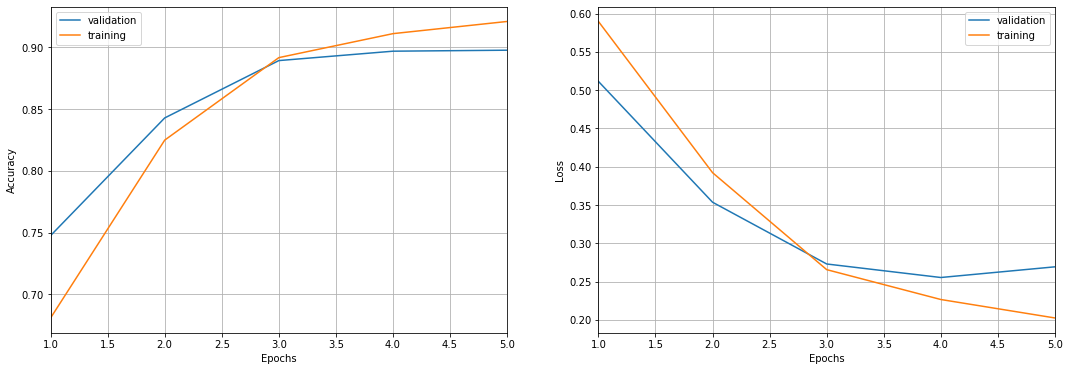

In [26]:
plot_learning_curves(history, numOfEpochs, savePlot=False)

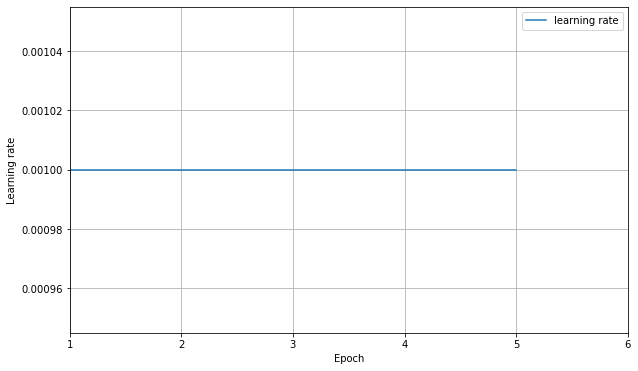

In [27]:
plot_learning_rate(loss_history_cb, numOfEpochs,  momentumPlot=False)